In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx
import jax_dataloader as jdl

from tqdm import tqdm
import typing as tp
import pandas as pd
import math
from dataclasses import asdict

import sys

import optax
import numpyro.distributions as D

from diffcv.dist.gaussian_mixture import GaussianMixture
from diffcv.mcmc.base import Sampler
from diffcv.mcmc.langevin import ULASampler, MALASampler
from diffcv.mcmc.pyro import HMCSampler
from diffcv.cv.nn import (
    CVMLP,
    ModelWithConstant,
    init_linear,
    normal_init,
    he_uniform_init,
    xavier_uniform_init,
    zero_init,
)
from diffcv.cv.training import CVTrainer, CVALSTrainer
from diffcv.cv.loss import DiffusionLoss, DiffLoss, VarLoss
from diffcv.logger import Logger, plot_log_results
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv.generator import ScalarGenerator
from diffcv.mcmc.estimator import Estimator
from diffcv.config import *

sns.set_style("darkgrid")

In [3]:
sampler_config = SamplerConfig(
    dim=10,
    gamma=8e-2,
    init_std=5.0,
)

sampling_config = SamplingConfig(
    steps=1_000,
    burnin_steps=1_000,
    skip_steps=2,
)

estimator_config = EstimatorConfig(
    sampling_config=sampling_config,
    total_samples=20_000,
    n_estimates=1_000,
)

2024-08-27 14:43:11.737966: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


true pi(f) =  1010.000


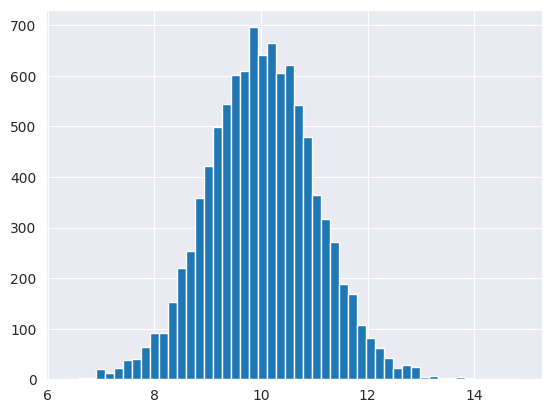

In [4]:
rng = jax.random.PRNGKey(50)

dist = D.MultivariateNormal(
    loc=10 * jnp.ones((sampler_config.dim), dtype=float),
    covariance_matrix=jnp.eye((sampler_config.dim), dtype=float),
)
log_prob = jax.jit(dist.log_prob)
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x**2).sum(axis=-1))
true_pi = (dist.mean**2).sum() + dist.variance.sum()

print(f"true pi(f) = {true_pi: .3f}")

sampler = MALASampler(log_prob=log_prob, **asdict(sampler_config))
rng, key = jax.random.split(rng)
samples = sampler(key, **asdict(sampling_config), n_chains=10).reshape(
    -1, sampler_config.dim
)

plt.hist(samples[:, 0], bins=50)
plt.show()

In [5]:
def estimate(key: jax.random.PRNGKey, fn: tp.Callable, estimator_config: EstimatorConfig):
    estimates = Estimator(fn, sampler)(key, estimator_config)
    return {"estimates": estimates, "bias": Estimator.bias(true_pi, estimates), "std": Estimator.std(estimates)}

In [6]:
results = {}

In [7]:
rng, key = jax.random.split(rng)
results["base"] = estimate(key, fn, estimator_config)
print(results["base"]["bias"], results["base"]["std"])

  0%|          | 0/1000 [00:00<?, ?it/s]

-0.00177001953125 1.5573097467422485


train_dataset length: 5120
eval_dataset length: 20480


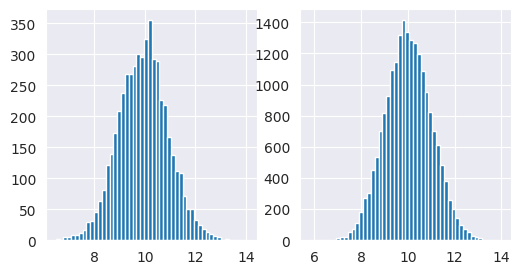

In [11]:
data_config = DataConfig(
    batch_size=1024,
    train_size=1024 * 5,
    eval_size=1024 * 20,
)

train_dataloader = get_data_from_sampler(
    key,
    data_config.batch_size,
    sampler,
    total_samples=data_config.train_size,
    sampling_config=sampling_config,
)
print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

eval_dataloader = get_data_from_sampler(
    key,
    data_config.batch_size,
    sampler,
    total_samples=data_config.eval_size,
    sampling_config=sampling_config,
)
print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataloader.dataloader.dataset[:, 0], bins=50)
plt.subplot(1, 2, 2)
plt.hist(eval_dataloader.dataloader.dataset[:, 0], bins=50)
plt.show()

In [12]:
def get_model(key: jax.random.PRNGKey, in_size: int, model_config: ModelConfig):
    # key1, key2 = jax.random.split(key, 2)
    # model = CVMLP(in_size=in_size, **asdict(model_config), key=key1)
    # model = init_linear(model, key2, normal_init, zero_init)
    model = CVMLP(in_size=in_size, **asdict(model_config), key=key)
    return model


def get_scheduler(scheduler_name: str, **kwargs):
    if scheduler_name == "exponential":
        return optax.exponential_decay(**kwargs)
    else:
        raise NotImplementedError(f"unknown scheduler: {scheduler_name}")


def get_optimizer(scheduler: optax.Schedule, optimizer_name: str, **kwargs):
    if optimizer_name == "sgd":
        return optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler, **kwargs)
    elif optimizer_name == "adam":
        return optax.inject_hyperparams(optax.adam)(learning_rate=scheduler, **kwargs)
    elif optimizer_name == "adamw":
        # weight_mask = lambda m: jax.tree_util.tree_map(lambda x: x.ndim > 1, m)
        return optax.inject_hyperparams(optax.adamw)(
            learning_rate=scheduler,
            **kwargs,
            # mask=weight_mask,
        )
    else:
        raise NotImplementedError(f"unknown optimizer: {optimizer_name}")

  0%|          | 0/50000 [00:00<?, ?it/s]

Early stopping at step 10000 due to no improvement in loss over 10000 steps.


  0%|          | 0/1000 [00:00<?, ?it/s]

0.00830078125 0.3390772342681885


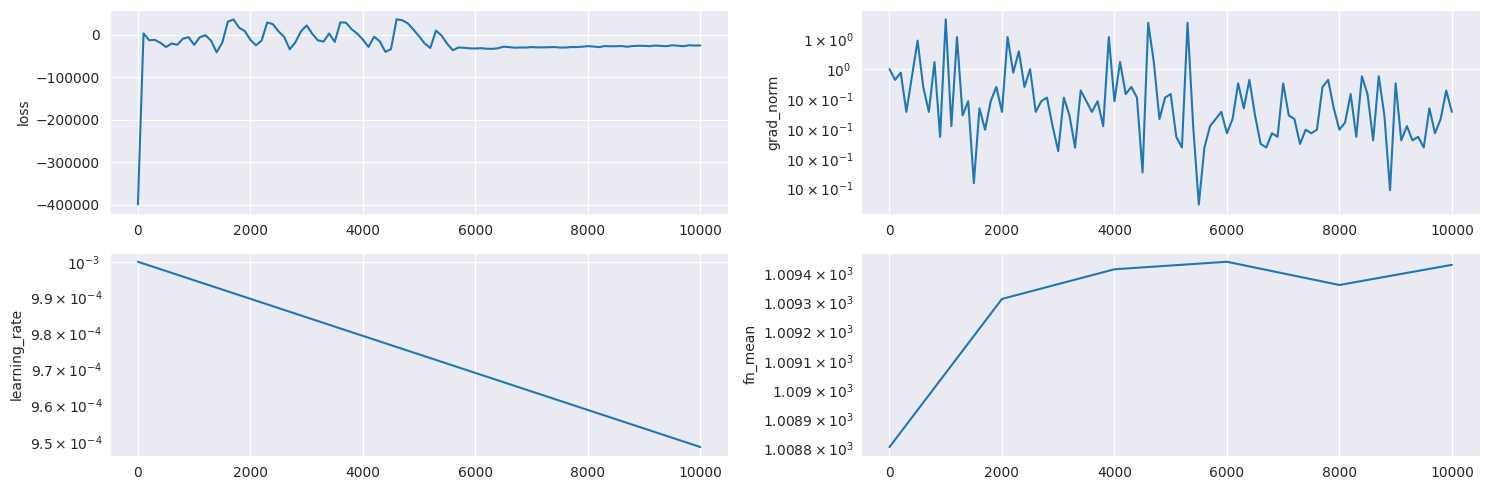

In [14]:
model_config = ModelConfig(
    depth=2,
    width_size=128,
    activation=requ,
)

trainer_config = TrainerConfig(
    grad_clipping=1,
    patience=10_000,
    eval_every_n_steps=2_000,
    n_steps=50_000,
)

logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion = get_model(key, sampler_config.dim, model_config)
loss = DiffusionLoss(fn=fn)


scheduler = get_scheduler(
    "exponential",
    init_value=1e-3,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer = get_optimizer(scheduler, "adamw", weight_decay=1e-2)

trainer = CVTrainer(
    model_diffusion,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    use_fn_mean=True,
    **asdict(trainer_config),
)

rng, key = jax.random.split(rng)
model_diffusion = trainer.train(key)

plot_log_results(logger)

generator_diffusion = ScalarGenerator(grad_log_prob, model_diffusion)
fn_with_cv = lambda x: fn(x) + generator_diffusion(x)

rng, key = jax.random.split(rng)
results["diffusion"] = estimate(key, fn_with_cv, estimator_config)
print(results["diffusion"]["bias"], results["diffusion"]["std"])

In [15]:
for layer in model_diffusion.mlp.layers:
    print("w", (layer.weight**2).sum(), layer.weight.shape)
    print("b", (layer.bias**2).sum(), layer.bias.shape)

w 34.459713 (128, 10)
b 20.022295 (128,)
w 84.32435 (128, 128)
b 21.529308 (128,)
w 0.6154258 (1, 128)
b 1.4227686 (1,)


In [16]:
jax.vmap(generator_diffusion)(samples).mean()

Array(-0.14638066, dtype=float32)

  0%|          | 0/50000 [00:00<?, ?it/s]

train fn_mean:  1010.010
train fn_mean:  1009.991
Early stopping at step 47608 due to no improvement in stein loss over 10000 steps.


  0%|          | 0/1000 [00:00<?, ?it/s]

-0.00543212890625 0.23629873991012573


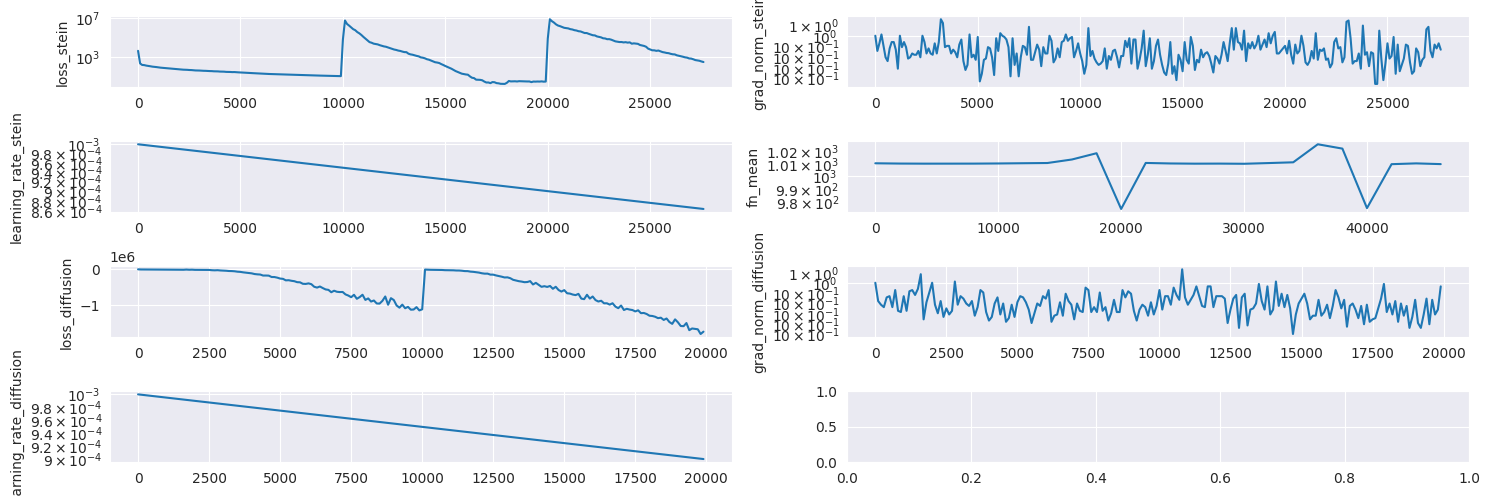

In [18]:
model_config = ModelConfig(
    depth=2,
    width_size=128,
    activation=requ,
)

trainer_config = TrainerALSConfig(
    grad_clipping=1,
    patience=10_000,
    eval_every_n_steps=2_000,
    n_steps=50_000,
    switch_steps=10_000,
)

logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion_als = get_model(key, sampler_config.dim, model_config)

scheduler_diffusion = get_scheduler(
    "exponential",
    init_value=1e-3,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer_diffusion = get_optimizer(scheduler_diffusion, "adamw", weight_decay=1e-2)

scheduler_stein = get_scheduler(
    "exponential",
    init_value=1e-3,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer_stein = get_optimizer(scheduler_stein, "adamw", weight_decay=1e-2)

loss_diffusion = DiffusionLoss(fn=fn)
loss_stein = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)


trainer = CVALSTrainer(
    model_diffusion_als,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer_diffusion,
    optimizer_stein,
    loss_diffusion,
    loss_stein,
    logger=logger,
    **asdict(trainer_config),
)

rng, key = jax.random.split(rng)
model_diffusion_als = trainer.train(key)

plot_log_results(logger)

generator_diffusion_als = ScalarGenerator(grad_log_prob, model_diffusion_als)
fn_with_cv = lambda x: fn(x) + generator_diffusion_als(x)

rng, key = jax.random.split(rng)
results["diffusion_als"] = estimate(key, fn_with_cv, estimator_config)
print(results["diffusion_als"]["bias"], results["diffusion_als"]["std"])

In [19]:
for layer in model_diffusion_als.mlp.layers:
    print("w", (layer.weight**2).sum(), layer.weight.shape)
    print("b", (layer.bias**2).sum(), layer.bias.shape)

w 15.650698 (128, 10)
b 128.83981 (128,)
w 53.857933 (128, 128)
b 67.98483 (128,)
w 3.3089337 (1, 128)
b 0.9603455 (1,)


In [20]:
jax.vmap(generator_diffusion_als)(samples).mean()

Array(0.32124403, dtype=float32)

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0.00054931640625 0.02366378717124462


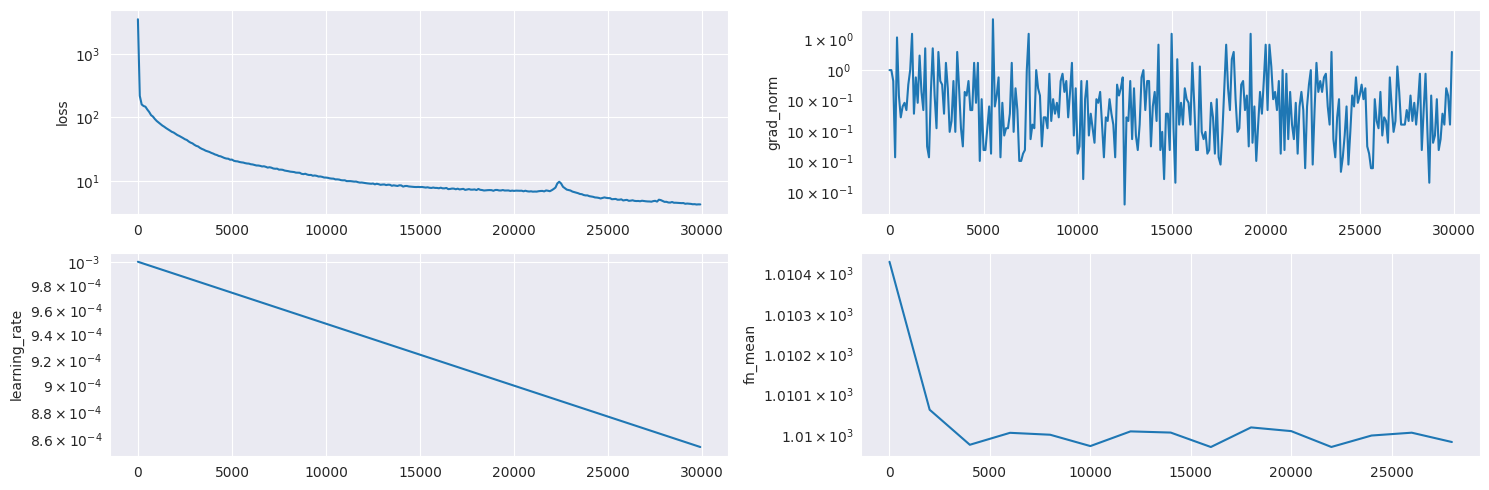

In [21]:
model_config = ModelConfig(
    depth=2,
    width_size=128,
    activation=requ,
)

trainer_config = TrainerConfig(
    grad_clipping=1,
    patience=10_000,
    eval_every_n_steps=2_000,
    n_steps=30_000,
)

logger = Logger()

rng, key = jax.random.split(rng)
model_diff = get_model(key, sampler_config.dim, model_config)
loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

scheduler = get_scheduler(
    "exponential",
    init_value=1e-3,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer = get_optimizer(scheduler, "adamw", weight_decay=1e-2)

trainer = CVTrainer(
    model_diff,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    **asdict(trainer_config),
)
rng, key = jax.random.split(rng)
model_diff = trainer.train(key)

plot_log_results(logger)

generator_diff = ScalarGenerator(grad_log_prob, model_diff)
fn_with_cv = lambda x: fn(x) + generator_diff(x)

rng, key = jax.random.split(rng)
results["diff"] = estimate(key, fn_with_cv, estimator_config)
print(results["diff"]["bias"], results["diff"]["std"])

In [25]:
{key: f"{results[key]['bias']: .3f}" for key in results}

{'base': '-0.002',
 'diffusion': ' 0.008',
 'diffusion_als': '-0.005',
 'diff': ' 0.001'}

In [26]:
{key: f"{results[key]['std']: .3f}" for key in results}

{'base': ' 1.557',
 'diffusion': ' 0.339',
 'diffusion_als': ' 0.236',
 'diff': ' 0.024'}

In [1]:
rhs = lambda x: (x**2).sum() - true_pi
rhs_samples = jax.vmap(rhs)(samples)
generator_diffusion_samples = -jax.vmap(generator_diffusion)(samples)
generator_diffusion_als_samples = -jax.vmap(generator_diffusion_als)(samples)
generator_diff_samples = -jax.vmap(generator_diff)(samples)

NameError: name 'jax' is not defined

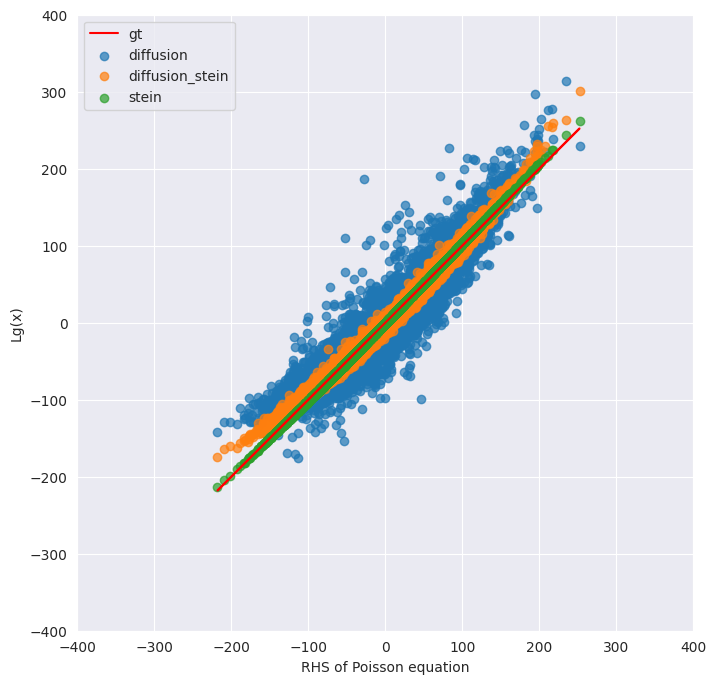

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(rhs_samples, rhs_samples, color="red")
plt.scatter(rhs_samples, generator_diffusion_samples, alpha=0.7)
plt.scatter(rhs_samples, generator_diffusion_als_samples, alpha=0.7)
plt.scatter(rhs_samples, generator_diff_samples, alpha=0.7)
plt.legend(["gt", "diffusion", "diffusion_stein", "stein"])
plt.axis("scaled")
minx = (
    min(
        generator_diff_samples.min(),
        generator_diffusion_samples.min(),
        generator_diffusion_als_samples.min(),
    )
    .astype(int)
    .item()
)
maxx = (
    max(
        generator_diff_samples.max(),
        generator_diffusion_samples.max(),
        generator_diffusion_als_samples.max(),
    )
    .astype(int)
    .item()
)
plt.ylim((-400, 400))
plt.xlim((-400, 400))
plt.xlabel("RHS of Poisson equation")
plt.ylabel("Lg(x)")
plt.show()

In [ ]:
# x = jnp.linspace(-6., 6., 100)
# plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
# plt.legend(["diffusion", "diffusion_stein", "stein"])

(50000,)

In [ ]:
# x = jnp.linspace(-6., 6., 100)
# rhs = lambda x: x ** 2 - 1 - a ** 2
# plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
# plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
# plt.legend(["rhs", "diffusion", "diffusion_als", "stein"])

In [ ]:
model_config = ModelConfig(
    depth=2,
    width_size=64,
    activation=requ,
)

trainer_config = TrainerConfig(
    grad_clipping=10,
    patience=10_000,
    eval_every_n_steps=2_000,
    n_steps=200_000,
)

logger = Logger()

rng, key = jax.random.split(rng)
model_var = get_model(key, sampler_config.dim, model_config)
rng, key = jax.random.split(rng)
model_var = ModelWithConstant(model_var, (1,), key)
loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)

scheduler = get_scheduler(
    "exponential",
    init_value=1e-4,
    transition_steps=20_000,
    decay_rate=0.9,
)

optimizer = get_optimizer(scheduler, "adamw", weight_decay=1e-1)

rng, key = jax.random.split(rng)
trainer = CVTrainer(
    model_var,
    fn,
    grad_log_prob,
    train_dataloader,
    eval_dataloader,
    optimizer,
    loss,
    logger,
    fn_mean=None,
    **asdict(trainer_config),
)
model_var = trainer.train(key)

plot_log_results(logger)

print(f"learned constant: {model_var.c}")
model_var = model_var.model

generator_var = ScalarGenerator(grad_log_prob, model_diff)
fn_with_cv = lambda x: fn(x) + generator_var(x)

rng, key = jax.random.split(rng)
results["var"] = estimate(key, fn_with_cv, estimator_config)
print(results["var"]["bias"], results["var"]["std"])

  0%|          | 0/200000 [00:00<?, ?it/s]

KeyboardInterrupt: 

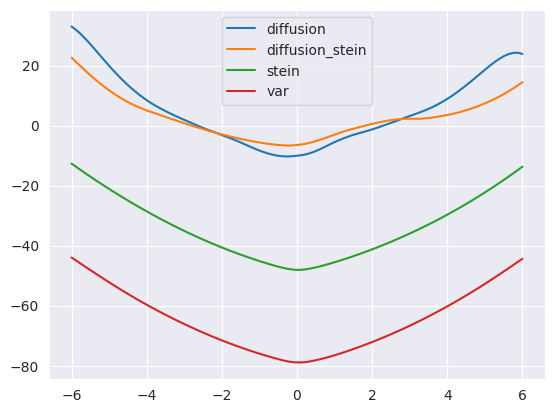

In [ ]:
x = jnp.linspace(-6.0, 6.0, 100)
plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["diffusion", "diffusion_stein", "stein", "var"])

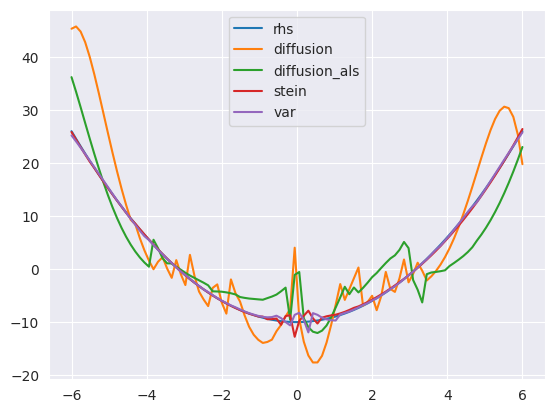

In [ ]:
x = jnp.linspace(-6.0, 6.0, 100)
rhs = lambda x: x**2 - 1 - a**2
plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["rhs", "diffusion", "diffusion_als", "stein", "var"])

In [ ]:
def diff_run(dist_dim: int):
    rng = jax.random.PRNGKey(50)

    dist = D.MultivariateNormal(
        loc=10 * jnp.ones((dist_dim), dtype=float),
        covariance_matrix=jnp.eye((dist_dim), dtype=float),
    )
    log_prob = jax.jit(dist.log_prob)
    grad_log_prob = jax.jit(jax.grad(dist.log_prob))

    fn = jax.jit(lambda x: (x**2).sum(axis=-1))
    true_pi = (dist.mean**2).sum() + dist.variance.sum()

    sampler = MALASampler(
        log_prob=log_prob,
        dim=dist_dim,
        n_samples=SAMPLER_N_SAMPLES,
        gamma=5e-2,
        burnin_steps=SAMPLER_N_BURNIN,
        init_std=3.0,
    )

    train_size = 900 + 10 * dist_dim
    eval_size = 20_000

    rng, key = jax.random.split(rng)
    train_dataloader = get_data_from_sampler(
        BATCH_SIZE, sampler, key, n_chains=train_size // SAMPLER_N_SAMPLES
    )
    print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

    rng, key = jax.random.split(rng)
    eval_dataloader = get_data_from_sampler(
        BATCH_SIZE, sampler, key, n_chains=eval_size // SAMPLER_N_SAMPLES
    )
    print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

    logger = Logger()

    rng, key = jax.random.split(rng)
    model = train_model(
        key=key,
        dist_dim=dist_dim,
        fn=fn,
        grad_log_prob=grad_log_prob,
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        lr=1e-3,
        loss_fn="diff",
        optim="adam",
        n_steps=40_000 + 100 * dist_dim,
        fn_mean=None,
        patience=20_000,
        logger=logger,
    )

    plot_log_results(logger)

    generator = ScalarGenerator(grad_log_prob, model)
    fn_with_cv = lambda x: fn(x) + generator(x)

    rng, key = jax.random.split(rng)
    estimates = Estimator(fn_with_cv, sampler)(key, n_chains=10, n_estimates=100)

    bias, std = Estimator.bias(true_pi, estimates), Estimator.std(estimates)
    print(dist_dim, bias, std)
    return bias, std

In [ ]:
from collections import defaultdict

In [ ]:
results = defaultdict(list)

train_dataset length: 10000
eval_dataset length: 20000


  0%|          | 0/140000 [00:00<?, ?it/s]

Early stopping at step 67221 due to no improvement in loss over 20000 steps.


  0%|          | 0/100 [00:00<?, ?it/s]

1000 5.25 43.34301


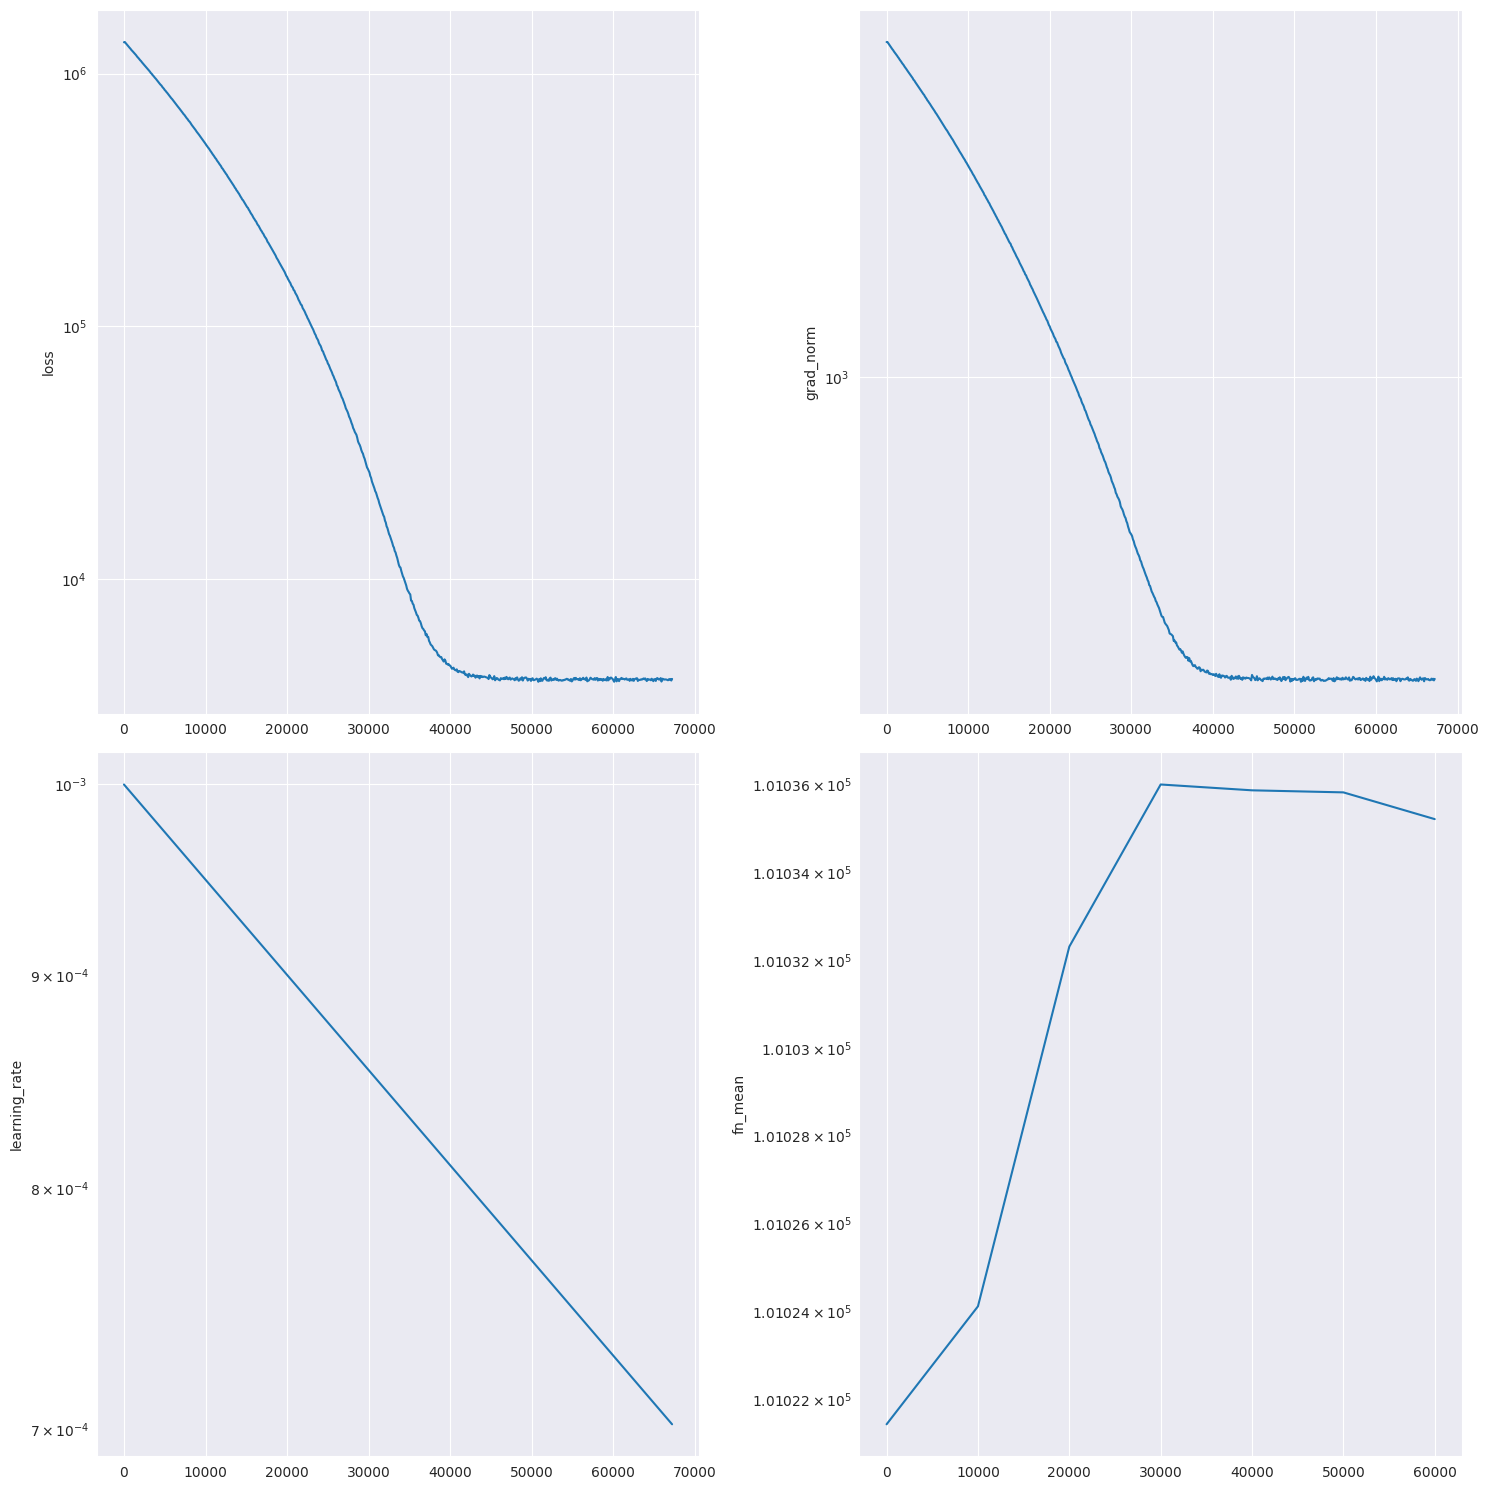

In [ ]:
for dist_dim in [1000]:
    bias, std = diff_run(dist_dim)
    results["diff"] = {"bias": bias, "std": std, "dim": dist_dim}

In [ ]:
t1000 = results["diff"]

In [ ]:
results["diff"]

[{'bias': Array(5.25, dtype=float32),
  'std': Array(43.34301, dtype=float32),
  'dim': 1000},
 {'bias': -6.1035156e-05, 'std': 0.08799228, 'dim': 10},
 {'bias': 0.025390625, 'std': 1.442239, 'dim': 100}]

In [ ]:
a = 3
dist = D.Mixture(
    mixing_distribution=D.Categorical(jnp.asarray([0.5, 0.5])),
    component_distributions=[D.Normal(loc=-a, scale=1), D.Normal(loc=a, scale=1)],
)

2024-08-14 15:00:11.737491: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
grad_log_prob = jax.grad(dist.log_prob)

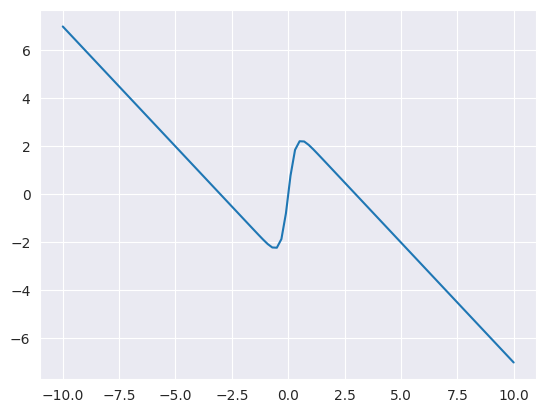

In [ ]:
x = np.linspace(-10, 10, 100)
y = jax.vmap(grad_log_prob)(x)
plt.plot(x, y)

$$
p_1(x) = \mathcal{N}(-a, 1), p_2(x) = \mathcal{N}(a, 1)
\\
p(x) = 0.5 p_1(x) + 0.5 p_2(x)
\\
\\
(\log p(x))' y'(x) + y''(x) = x^2 - 1 - a^2
\\
y'(x) = u(x)
\\
u(x) = \frac{C(x)}{p(x)}
\\
C(x) = \int_{-\infty}^{x} (t^2 - 1 - a^2) p(t) dt
\\
y(x) = \int_{-\infty}^{x} \frac{C(t)}{p(t)} dt + C
$$

In [ ]:
from scipy.integrate import quad

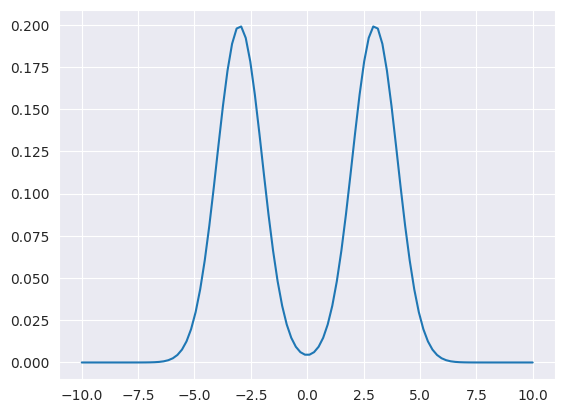

In [ ]:
def get_normal_density(loc, scale=1):
    def density(x):
        return (
            1
            / (np.sqrt(2 * np.pi) * scale)
            * np.exp(-0.5 / (scale * scale) * ((x - loc) ** 2))
        )

    return density


def get_mixture_density(coeffs, locs, scales):
    ps = [get_normal_density(loc, scale) for loc, scale in zip(locs, scales)]

    def density(x):
        ans = 0.0
        for c, p in zip(coeffs, ps):
            ans += c * p(x)
        return ans

    return density


p_mixture = get_mixture_density([0.5, 0.5], [-3, 3], [1, 1])
plt.plot(x, p_mixture(x))

In [ ]:
def C(x):
    return (x**2 - 1 - a**2) * p_mixture(x)


def get_u(C_int):
    def u(x):
        return C_int


ts = np.linspace(-1000, 1000, 1000)
C_int = [quad(C, -np.inf, t)[0] for t in ts]